# Mobile Games A/B Testing with Cookie Cats
##### Analyze an A/B test from the popular mobile puzzle game, Cookie Cats
##### Key words: A/B Testing, Retention, Bootstrapping

### 1. Project Background

## Data Collection
<p>Gather the required data from various sources, ensuring its accuracy and relevance to your goals</p>
<p>The dataset contains information on player rentention of a split test where the first gate in Cookie Cats was moved from level 30 to level 40. A total of 90,189 players installed the game while the A/B test was running.</p>

## Data Cleaning
Clean the data to address any errors, inconsistencies, missing values, or outliers. This step ensures that the data is accurate and reliable for analysis

In [68]:
# Import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats

In [18]:
# Load Data
path = '../Mobile-Games-AB-Testing/input/cookie_cats.csv'
df = pd.read_csv(path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - Unique Key: a unique number for each player</li>
<li><code>version</code> - Object: whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40) </li>
<li><code>sum_gamerounds</code> - Integer: the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - Boolean: did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - Boolean: did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

In [19]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


&rarr; No missing value in this dataset

In [25]:
# Check if the player ID is unique? -> True
print(df.userid.nunique() == df.shape[0]) 
# Variables stats summary: sum_gamerounds
df.describe()["sum_gamerounds"]

True


count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [29]:
# Number of players in each A/B group
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

&rarr; The number of players is roughly the same in the control and test group

#### Analyzing Players Behavior
The distribution of <code>sum_gamerounds</code> would give us a rough idea of how many game rounds were played by a player during the first week after installing the game

Text(0, 0.5, 'Number of game rounds')

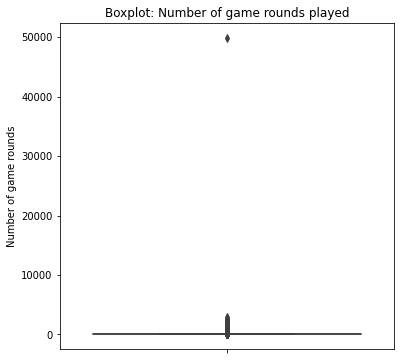

In [70]:
# Distribution of game rounds
plt.figure(figsize=(6,6))
ax = sns.boxplot(y='sum_gamerounds', data=df)
ax.set_title('Boxplot: Number of game rounds played')
ax.set_ylabel('Number of game rounds')

&rarr; Obviously, there is an outlier. This player had around 50,000 game rounds during the first week after installing the game! The outlier can make the boxplot not informative and would influence the statistical significance of the A/B test results

Text(0, 0.5, 'Number of game rounds')

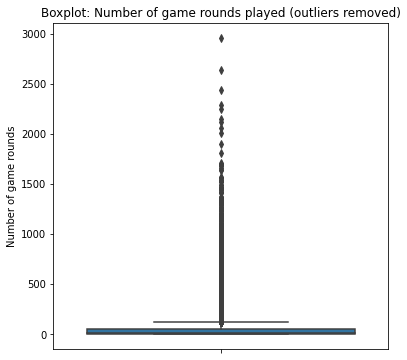

In [73]:
# Remove the Outlier
df_clean=df[df.sum_gamerounds < df.sum_gamerounds.max()]
# Boxplot of game rounds
plt.figure(figsize=(6,6))
ax = sns.boxplot(y='sum_gamerounds', data=df_clean)
ax.set_title('Boxplot: Number of game rounds played (outliers removed)')
ax.set_ylabel('Number of game rounds')

## EDA

Text(0, 0.5, 'Number of game rounds')

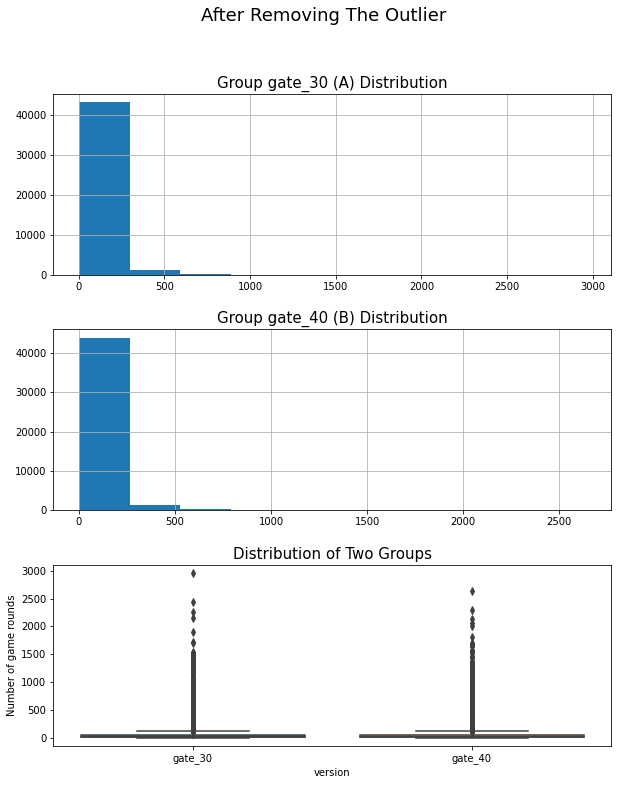

In [83]:
fig, axes = plt.subplots(3, 1, figsize = (10,12))
df_clean[(df_clean['version'] == 'gate_30')].hist('sum_gamerounds', ax = axes[0])
df_clean[(df_clean['version'] == 'gate_40')].hist('sum_gamerounds', ax = axes[1])
sns.boxplot(x = df_clean['version'], y = df_clean['sum_gamerounds'], ax = axes[2])

plt.suptitle("After Removing The Outlier", fontsize = 18)
axes[0].set_title("Group gate_30 (A) Distribution", fontsize = 15)
axes[1].set_title("Group gate_40 (B) Distribution", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)
axes[2].set_ylabel('Number of game rounds')

Text(0, 0.5, 'Number of players')

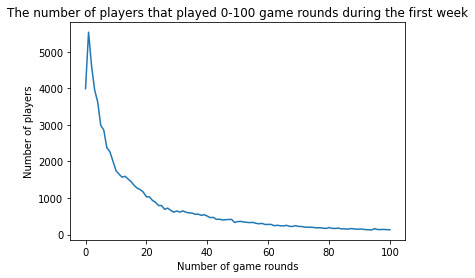

In [100]:
# Plot the distribution of players that played 0 to 100 game rounds during the first week
df_plot = df_clean.groupby('sum_gamerounds').count().reset_index()
plt.figure(figsize=(6,4))
ax = sns.lineplot(x='sum_gamerounds', y='userid', data=df_plot.head(n=101))
ax.set_title('The number of players that played 0-100 game rounds during the first week')
ax.set_xlabel('Number of game rounds')
ax.set_ylabel('Number of players')
# plt.savefig('Game Round Distribution.png')

&rarr; The right-skewed distribution indicates that there are a relatively small number of players who have played a significantly higher number of game rounds compared to the majority of players. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

## Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (<code>sum_gamerounds</code>=0), some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.
<p>A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [101]:
# Overall 1-day retention
print('Overall 1-day retention:',df_clean.retention_1.mean())

Overall 1-day retention: 0.4452144409455803


&rarr; A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

In [102]:
# Calculating 1-day retention for each AB-group
Ra,Rb=df_clean.groupby('version')['retention_1'].mean()
print('gate_30 1-day retention:',Ra)
print('gate_40 1-day retention:',Rb)

gate_30 1-day retention: 0.4481979462627799
gate_40 1-day retention: 0.44228274967574577


<p>
&rarr; It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). 
<br /> &nbsp; &nbsp; It's a small change, but even small changes in retention can have a large impact. 
<br /> &nbsp; &nbsp; But while we are certain of the difference in the data, <strong>how certain should we be that a gate at level 40 will be worse in the future?</strong>

## Bootstrapping: Should we be confident in the difference?
<p> There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

<AxesSubplot:ylabel='Density'>

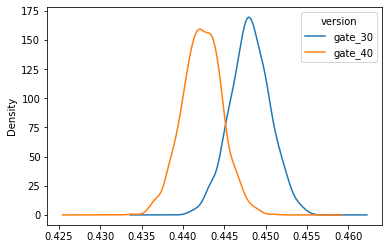

In [103]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df_clean.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

Probability that 1-day retention is greater when the gate is at level 30: 0.963


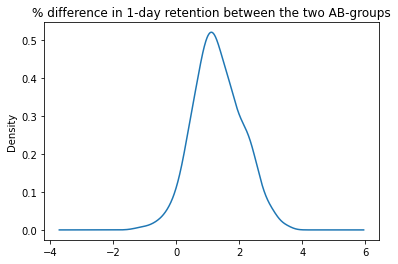

In [109]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())